In [42]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [36]:
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [7]:
pd.set_option('display.max_columns', 25)

In [16]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


control_median =  150000.0
test_median =  90000.0


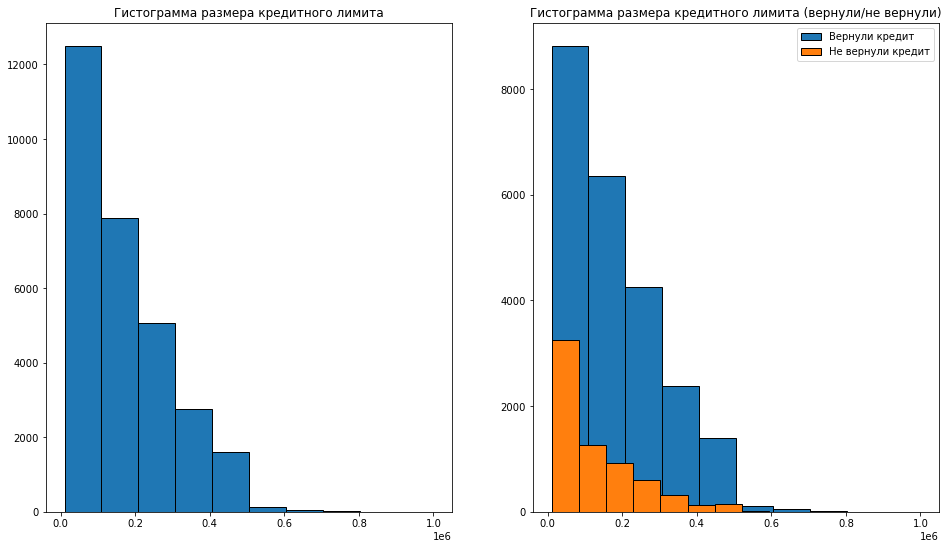

In [68]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title('Гистограмма размера кредитного лимита')
plt.hist(data['LIMIT_BAL'], edgecolor='k')
# plt.show()

# вернули кредит
control = data[data.default == 0]['LIMIT_BAL']
# control_median = np.median(control['LIMIT_BAL'])
print('control_median = ', control_median)

# не вернули кредит
test = data[data.default == 1]['LIMIT_BAL']
# test_median = np.median(test['LIMIT_BAL'])
print('test_median = ', test_median)

# медианы выборок различны, но это лишь грубое приближение

plt.subplot(122)
plt.title('Гистограмма размера кредитного лимита (вернули/не вернули)')
plt.hist(control, label='Вернули кредит', edgecolor='k')
plt.hist(test, label='Не вернули кредит', edgecolor='k')
plt.legend()
plt.show()


In [107]:
# функция для построения доверительных интервалов для медиан (на основе распредления Бернулли)

sample = control
alpha = 0.05
p = 0.5

# def my_binom_zconfint(sample, n, p, alpha=0.05):
    q = 1 - p
    n = len(sample)
    mean = n*p
    variance = n*p*q
    z = z = stats.norm.ppf(1 - alpha/2.)
    low_number = int(round(mean - z*np.sqrt(variance)))
    low = np.sort(sample)[low_number]
    high_number = int(round(mean + z*np.sqrt(variance)))
high =  np.sort(sample)[high_number]
    return low, high


11532
11532
150000


In [100]:
data.LIMIT_BAL.loc[data.default==1].values

array([ 20000, 120000,  70000, ...,  30000,  80000,  50000], dtype=int64)

In [104]:
# 1a) получим интервальные оценки медианных значений выборок критерием знаков на основе биноминальног распределения
control_s = np.sort(control.loc)
test_s = np.sort(test.loc)


interval = my_binom_zconfint(control, 0.5)
print('Доверительный интервал для медианы среди вернувших кредит:')
print('[{}; {}]'.format(int(interval[0]), int(interval[1])))

interval = np.round(my_binom_zconfint(len(test), 0.5))
print('Доверительный интервал для медианы среди не вернувших кредит:')
print('[{}; {}]'.format(int(interval[0]), int(interval[1])))

AxisError: axis -1 is out of bounds for array of dimension 0

In [69]:
# 1b) выборки имеют разный размер, поэтому будем использовать непараметрический критерий Манна-Уитни
res = stats.mannwhitneyu(control, test)
print(res)
print('p-value = ', res[1])
# значение p-value значительно меньше порога, поэтому нулевая гипотеза отвергается, а значит распределения выборок различны'

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)
p-value =  6.127742909111652e-190


In [30]:
control['LIMIT_BAL']

2         90000
3         50000
4         50000
5         50000
6        500000
          ...  
29990    140000
29992     10000
29993    100000
29995    220000
29996    150000
Name: LIMIT_BAL, Length: 23364, dtype: int64